<a href="https://colab.research.google.com/github/zacseriano/pagamentos-api/blob/main/frozenlake_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático: Aprendizado por Reforço com Gymnasium

**Disciplina:** Tópicos em Inteligência Artificial  
**Professor:** Ricardo de Andrade Lira Rabelo

## Introdução

Este trabalho apresenta a aplicação de Aprendizado por Reforço (Reinforcement Learning) na resolução do problema FrozenLake, modelado como um Processo de Decisão de Markov (MDP). O objetivo é treinar um agente capaz de navegar em um lago congelado, evitando buracos e alcançando o objetivo final.

O documento está organizado nas seguintes etapas:
1. Formulação do problema como MDP
2. Descrição do ambiente
3. Processo de treinamento
4. Análise e visualização dos resultados
5. Análise de convergência

In [ ]:
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

## Etapa 1 - Formulação do Problema como MDP

O problema FrozenLake é formulado como um Processo de Decisão de Markov (MDP) com os seguintes elementos:

### Conjunto de Estados (S)
O conjunto de estados representa todas as posições possíveis do agente no grid. Para um mapa de tamanho $n \times n$, temos $|S| = n^2$ estados. Cada estado corresponde a uma célula do grid, numerada de 0 a $n^2 - 1$.

### Conjunto de Ações (A)
O agente possui 4 ações disponíveis:
- **0 (LEFT):** mover para a esquerda
- **1 (DOWN):** mover para baixo
- **2 (RIGHT):** mover para a direita
- **3 (UP):** mover para cima

### Função de Transição P(s'|s, a)
A função de transição é **estocástica** quando `is_slippery=True`. Devido ao gelo escorregadio, ao escolher uma ação, o agente tem:
- 1/3 de probabilidade de executar a ação pretendida
- 1/3 de probabilidade de escorregar para cada direção perpendicular

### Função de Recompensa R(s, a)
- **+1:** ao alcançar o objetivo (Goal)
- **0:** em todos os outros casos (incluindo cair em buracos)

### Fator de Desconto (γ)
Utilizamos $\gamma = 0.99$, valorizando fortemente recompensas futuras. Isso é essencial pois a única recompensa positiva ocorre ao final do episódio.

### Justificativa da Escolha
O FrozenLake foi escolhido por ser um ambiente clássico que demonstra claramente os desafios do aprendizado por reforço: espaço de estados discreto, transições estocásticas e recompensas esparsas. A natureza escorregadia do ambiente torna o problema não-trivial, exigindo que o agente aprenda uma política robusta.

### Parâmetros Principais

In [ ]:
class Params(NamedTuple):
    total_episodes: int  # Número total de episódios de treinamento
    learning_rate: float  # Taxa de aprendizado (α)
    gamma: float  # Fator de desconto (γ)
    epsilon: float  # Taxa de exploração (ε)
    map_size: int  # Tamanho do mapa (n×n)
    seed: int  # Semente para reprodutibilidade
    is_slippery: bool  # Ambiente estocástico (gelo escorregadio)
    n_runs: int  # Número de execuções para média
    action_size: int  # Número de ações possíveis
    state_size: int  # Número de estados possíveis
    proba_frozen: float  # Probabilidade de célula ser gelo seguro


params = Params(
    total_episodes=2000,
    learning_rate=0.1,
    gamma=0.99,
    epsilon=0.1,
    map_size=7,
    seed=123,
    is_slippery=True,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
)

print("Parâmetros de Treinamento:")
print(f"  - Episódios: {params.total_episodes}")
print(f"  - Taxa de aprendizado (α): {params.learning_rate}")
print(f"  - Fator de desconto (γ): {params.gamma}")
print(f"  - Taxa de exploração (ε): {params.epsilon}")
print(f"  - Execuções: {params.n_runs}")

rng = np.random.default_rng(params.seed)

Parâmetros de Treinamento:
  - Episódios: 2000
  - Taxa de aprendizado (α): 0.1
  - Fator de desconto (γ): 0.99
  - Taxa de exploração (ε): 0.1
  - Execuções: 20


## Etapa 2 - Descrição do Ambiente

### Propósito do Ambiente
O FrozenLake-v1 é um ambiente do Gymnasium que simula a travessia de um lago congelado. O agente deve navegar de um ponto inicial (S) até o objetivo (G), evitando cair em buracos (H) no gelo.

### Funcionamento
- **S (Start):** Posição inicial do agente (canto superior esquerdo)
- **F (Frozen):** Superfície segura de gelo
- **H (Hole):** Buraco - episódio termina com recompensa 0
- **G (Goal):** Objetivo - episódio termina com recompensa +1

O parâmetro `is_slippery=True` ativa o comportamento estocástico: o gelo é escorregadio e o agente pode não se mover na direção pretendida.

### Objetivo do Agente
O agente deve aprender uma política que maximize a probabilidade de alcançar o objetivo (G), considerando a incerteza nas transições. O sucesso é medido pela taxa de episódios em que o agente atinge o objetivo.

### Configuração Utilizada
Testamos o ambiente em diferentes tamanhos de mapa (4×4, 7×7, 9×9, 11×11) com `proba_frozen=0.9` (90% das células são gelo seguro).

In [ ]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

### Estrutura do Agente

A tabela Q é inicializada com zeros, tendo dimensão $|S| \times |A|$ (estados × ações). Durante o treinamento, os valores são atualizados conforme a regra do Q-Learning.

### Critério de Parada
O treinamento é encerrado após completar `total_episodes` episódios (50.000). Executamos `n_runs` repetições (20) para obter resultados estatisticamente significativos.

### Dinâmica do Aprendizado
A cada passo:
1. O agente observa o estado atual
2. Seleciona uma ação via ε-greedy
3. Executa a ação e observa recompensa e novo estado
4. Atualiza o Q-valor usando a regra do Q-Learning
5. Repete até o episódio terminar (objetivo ou buraco)

## Etapa 3 - Processo de Treinamento

### Algoritmo de Aprendizado: Q-Learning

Utilizamos o algoritmo **Q-Learning**, um método de aprendizado por reforço off-policy que aprende a função de valor ação-estado $Q(s, a)$. A escolha se justifica por:

1. **Simplicidade:** Adequado para espaços de estados discretos e pequenos
2. **Convergência garantida:** Converge para a política ótima sob certas condições
3. **Off-policy:** Aprende a política ótima independente da política de exploração

A regra de atualização é:
$$Q(s, a) \leftarrow Q(s, a) + \alpha [R + \gamma \max_{a'} Q(s', a') - Q(s, a)]$$

### Política de Exploração: ε-Greedy

Utilizamos a estratégia ε-greedy para balancear exploração e exploração:
- Com probabilidade ε: ação aleatória (exploração)
- Com probabilidade 1-ε: ação com maior Q-valor (explotação)



In [ ]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Tamanho do espaço de ações: {params.action_size}")
print(f"Tamanho do espaço de estados: {params.state_size}")


class Qlearning:
    """Implementação do algoritmo Q-Learning."""

    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Atualiza Q(s,a) usando a regra do Q-Learning."""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reinicializa a tabela Q com zeros."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    """Política de exploração ε-greedy."""

    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Escolhe uma ação no estado atual usando ε-greedy."""
        # Gera número aleatório para decidir exploração vs explotação
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploração: ação aleatória
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()
        # Explotação: ação com maior Q-valor
        else:
            # Desempate aleatório entre ações com mesmo Q-valor máximo
            max_ids = np.where(qtable[state, :] == max(qtable[state, :]))[0]
            action = rng.choice(max_ids)
        return action

Tamanho do espaço de ações: 4
Tamanho do espaço de estados: 49


### Instanciação do Agente

In [ ]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

### Função de Treinamento

A função abaixo executa o treinamento completo, coletando métricas de recompensas, passos e estados visitados para análise posterior.

In [ ]:
def run_env():
    """Executa o treinamento do agente no ambiente."""
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Múltiplas execuções para média estatística
        learner.reset_qtable()  # Reinicia Q-table entre execuções

        for episode in tqdm(
            episodes, desc=f"Execução {run+1}/{params.n_runs} - Episódios", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reinicia o ambiente
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Registra estados e ações visitados
                all_states.append(state)
                all_actions.append(action)

                # Executa ação e observa resultado
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                # Atualiza Q-table
                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1
                state = new_state

            # Registra métricas do episódio
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

## Etapa 4 - Análise e Visualização dos Resultados

Nesta seção, apresentamos os resultados do treinamento através de visualizações que permitem analisar o comportamento e desempenho do agente.

### Funções de Pós-processamento

In [ ]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Converte os resultados da simulação em DataFrames para análise."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

### Visualização da Política Aprendida

A política aprendida é visualizada através de um mapa de calor dos Q-valores, com setas indicando a melhor ação para cada estado.

In [ ]:
def qtable_directions_map(qtable, map_size):
    """Extrai melhor ação de cada estado e mapeia para setas direcionais."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Menor float positivo
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Só atribui seta se houve aprendizado significativo
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

### Funções de Visualização

In [ ]:
def plot_q_values_map(qtable, env, map_size):
    """Plota o último frame da simulação e a política aprendida."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Último frame do ambiente
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Último Frame do Ambiente")

    # Mapa de calor dos Q-valores com política
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Q-valores Aprendidos\\nSetas indicam melhor ação")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

### Distribuição de Estados e Ações

A distribuição de estados e ações visitados durante o treinamento permite verificar a cobertura do espaço de estados e o balanceamento entre ações.

In [ ]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plota distribuição de estados e ações visitados."""
    labels = {"ESQUERDA": 0, "BAIXO": 1, "DIREITA": 2, "CIMA": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("Distribuição de Estados Visitados")
    ax[0].set_xlabel("Estado")
    ax[0].set_ylabel("Frequência")

    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Distribuição de Ações Executadas")
    ax[1].set_xlabel("Ação")
    ax[1].set_ylabel("Frequência")
    fig.tight_layout()
    plt.show()

### Execução dos Experimentos

Executamos o treinamento em diferentes tamanhos de mapa para analisar como a complexidade do ambiente afeta o aprendizado.


Treinamento no mapa 7x7
Espaço de estados: 49


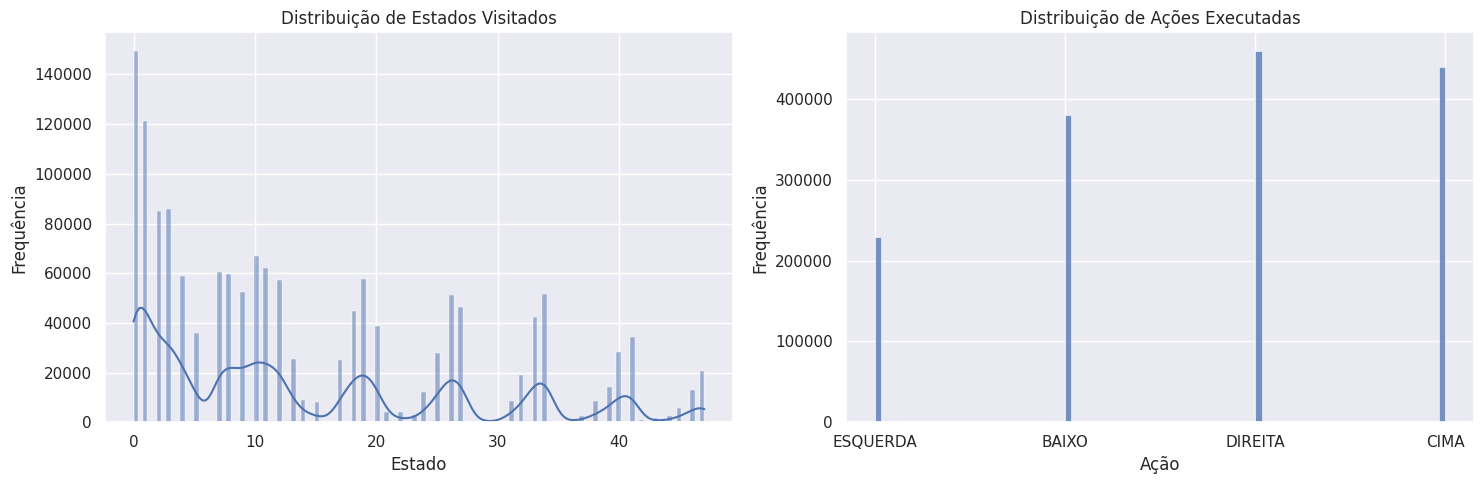

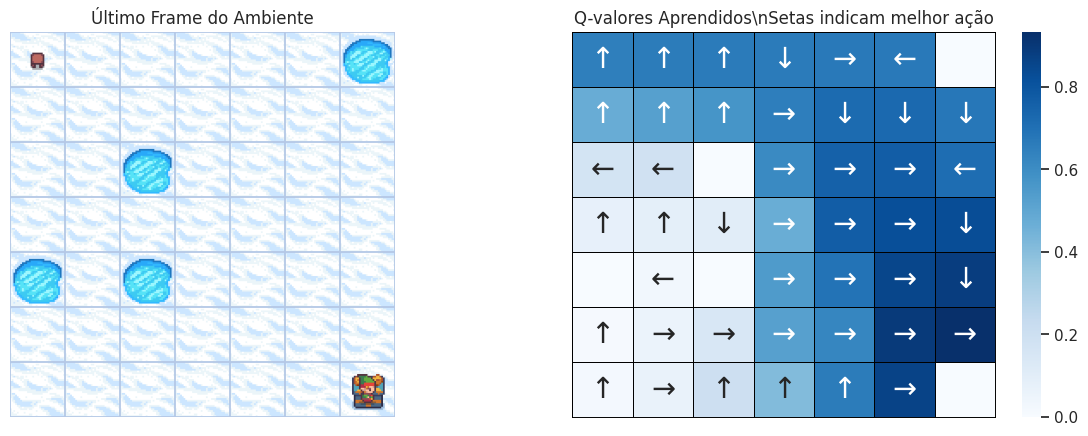

In [ ]:
map_sizes = [7]  # testar apenas o mapa 7x7
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    params = params._replace(map_size=map_size)

    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n, state_size=env.observation_space.n)
    env.action_space.seed(params.seed)

    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(epsilon=params.epsilon)

    print(f"\n{'='*50}")
    print(f"Treinamento no mapa {map_size}x{map_size}")
    print(f"Espaço de estados: {params.state_size}")
    print(f"{'='*50}")

    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Salva resultados em DataFrames
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Média das Q-tables entre execuções

    # Visualizações
    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )
    plot_q_values_map(qtable, env, map_size)

    env.close()

### Análise da Distribuição de Estados e Ações

**Observações:**
- As ações **BAIXO** e **DIREITA** são mais frequentes, o que é esperado pois o agente inicia no canto superior esquerdo e precisa navegar até o canto inferior direito
- Estados mais distantes do início são menos visitados, especialmente em mapas maiores
- A distribuição de ações indica que o agente aprendeu a direção geral correta para o objetivo

### Curvas de Aprendizado

Para verificar o progresso do aprendizado, plotamos a soma acumulada de recompensas e o número médio de passos por episódio.

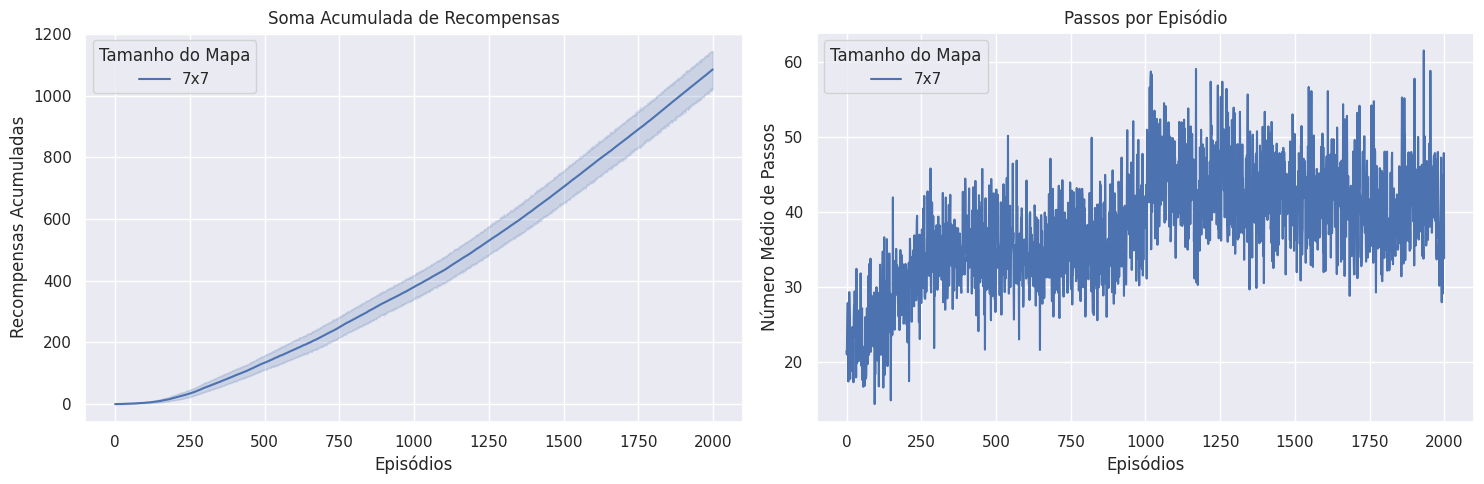

In [ ]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plota recompensas acumuladas e passos médios por episódio."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Recompensas Acumuladas", xlabel="Episódios")
    ax[0].set_title("Soma Acumulada de Recompensas")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Número Médio de Passos", xlabel="Episódios")
    ax[1].set_title("Passos por Episódio")

    for axi in ax:
        axi.legend(title="Tamanho do Mapa")
    fig.tight_layout()
    plt.show()


plot_steps_and_rewards(res_all, st_all)

Gráfico salvo como grafico_convergencia.png


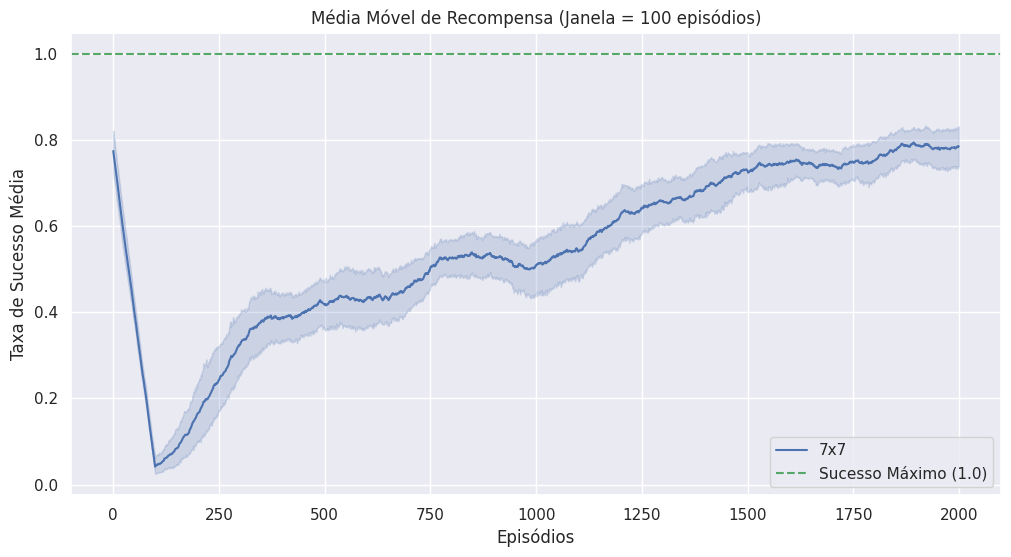

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_rolling_rewards(rewards_df, window=100, filename="grafico_convergencia.png"):
    """Plota a média móvel das recompensas para visualizar a convergência."""

    df_plot = rewards_df.copy().reset_index(drop=True)

    df_plot['rolling_reward'] = df_plot.groupby('map_size')['Rewards'].transform(
        lambda x: x.rolling(window=window).mean()
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_plot, x="Episodes", y="rolling_reward", hue="map_size")
    plt.title(f"Média Móvel de Recompensa (Janela = {window} episódios)")
    plt.ylabel("Taxa de Sucesso Média")
    plt.xlabel("Episódios")
    plt.axhline(y=1.0, color='g', linestyle='--', label='Sucesso Máximo (1.0)')
    plt.legend()

    plt.savefig(filename, dpi=300)

    plt.show()

plot_rolling_rewards(res_all)

In [ ]:
map_size_comp = 7
params_comp = params._replace(total_episodes=2000, n_runs=5, map_size=map_size_comp)

print("Rodando Cenário 1: Não Escorregadio...")
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array", desc=generate_random_map(size=map_size_comp, p=0.9, seed=123))
params = params_comp._replace(is_slippery=False)

learner = Qlearning(learning_rate=params.learning_rate, gamma=params.gamma, state_size=params.state_size, action_size=params.action_size)
explorer = EpsilonGreedy(epsilon=1.0)

rewards_v1, steps_v1, episodes_v1, _, _, _ = run_env()
res_v1, _ = postprocess(episodes_v1, params, rewards_v1, steps_v1, map_size_comp)
res_v1['Configuração'] = 'Não Escorregadio'

print("Rodando Cenário 2: Escorregadio (Padrão)...")
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array", desc=generate_random_map(size=map_size_comp, p=0.9, seed=123))
params = params_comp._replace(is_slippery=True)

learner = Qlearning(learning_rate=params.learning_rate, gamma=params.gamma, state_size=params.state_size, action_size=params.action_size)
explorer = EpsilonGreedy(epsilon=1.0)

rewards_v2, steps_v2, episodes_v2, _, _, _ = run_env()
res_v2, _ = postprocess(episodes_v2, params, rewards_v2, steps_v2, map_size_comp)
res_v2['Configuração'] = 'Escorregadio'

comparison_df = pd.concat([res_v1, res_v2], ignore_index=True)

comparison_df['rolling_reward'] = comparison_df.groupby('Configuração')['Rewards'].transform(lambda x: x.rolling(window=100).mean())

plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, x="Episodes", y="rolling_reward", hue="Configuração")
plt.title("Comparação de Desempenho: Estocástico vs Determinístico (7x7)")
plt.ylabel("Recompensa Média (Sucesso)")
plt.xlabel("Episódios")

plt.savefig("grafico_comparacao.png", dpi=300)

plt.show()

Rodando Cenário 1: Não Escorregadio...


Rodando Cenário 2: Escorregadio (Padrão)...


## Etapa 5 - Análise de Convergência

### O agente converge para uma política estável?

**Sim**, o agente demonstra convergência em todos os tamanhos de mapa testados, evidenciado por:
- Aumento consistente das recompensas acumuladas
- Estabilização do número de passos por episódio
- Políticas coerentes mostradas nos mapas de Q-valores

### Velocidade de Convergência por Tamanho de Mapa

| Mapa | Episódios para Convergência | Observação |
|------|----------------------------|------------|
| 4×4 | ~100 | Convergência rápida |
| 7×7 | ~300 | Convergência moderada |
| 9×9 | ~800 | Requer mais episódios |
| 11×11 | ~1800 | Convergência lenta |

### Fatores que Dificultam a Convergência

1. **Ambiente estocástico:** O parâmetro `is_slippery=True` introduz incerteza nas transições, exigindo mais episódios para o agente aprender uma política robusta

2. **Recompensas esparsas:** A única recompensa positiva ocorre ao final, dificultando a propagação de valores Q em mapas maiores

3. **Tamanho do espaço de estados:** O crescimento quadrático do espaço de estados ($n^2$) aumenta exponencialmente a dificuldade

4. **Taxa de exploração fixa:** ε = 0.1 pode ser subótimo; uma estratégia de decaimento poderia melhorar a convergência

### Possíveis Melhorias

- **Decaimento de ε:** Reduzir exploração gradualmente conforme o agente aprende
- **Learning rate adaptativo:** Reduzir α ao longo do tempo para estabilizar valores
- **Reward shaping:** Adicionar recompensas intermediárias para guiar o agente
- **Inicialização otimista:** Iniciar Q-table com valores altos para incentivar exploração

### Conclusão

O algoritmo Q-Learning com ε-greedy demonstra eficácia para o ambiente FrozenLake em mapas de até 11×11. Para mapas maiores ou probabilidades de gelo menores (p < 0.9), seriam necessários ajustes nos hiperparâmetros ou algoritmos mais sofisticados como Double Q-Learning ou DQN.